In [2]:
import numpy as np
import csv
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

In [6]:
train_file = 'data/train.csv'
test_file  = 'data/test.csv'
soln_file  = 'data/user_median.csv'

In [7]:
df = pd.read_csv(train_file, header=0)

In [8]:
df.head()

,user,artist,plays
0,eb1c57ddc9e0e2d005169d3a1a96e8dd95e3af03,5a8e07d5-d932-4484-a7f7-e700793a9c94,554
1,44ce793a6cd9d20f13f4a576a818ef983314bb5d,a3a92047-be1c-4f3e-8960-c4f8570984df,81
2,da9cf3f557161d54b76f24db64be9cc76db008e3,eeb1195b-f213-4ce1-b28c-8565211f8e43,708
3,8fa49ab25d425edcf05d44bfc1d5aea895287d81,a1419808-65d3-4d40-998c-1a0bac65eabc,265
4,b85fcaef67d2669cd99b334b5e8c8705263db2cf,a3cb23fc-acd3-4ce0-8f36-1e5aa6a18432,220


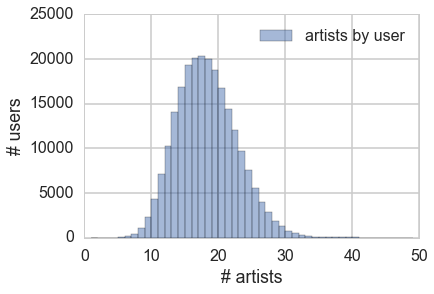

In [9]:
#your code here
artists_user = df.groupby('user')['artist'].count()
plt.hist(artists_user, alpha=0.5, bins=np.arange(1,50,1), label="artists by user");
plt.xlabel('# artists')
plt.ylabel('# users')
#plt.xticks(np.arange(0,90,5))
plt.legend()

In [10]:
np.mean(df.groupby('user')['artist'].count())

17.809915725761513

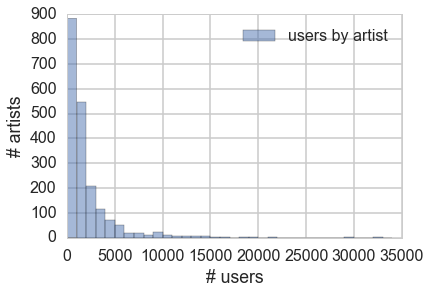

In [11]:
#your code here
users_artist = df.groupby('artist')['user'].count()
plt.hist(users_artist, alpha=0.5, bins=np.arange(1,35000,1000), label="users by artist");
plt.xlabel('# users')
plt.ylabel('# artists')
plt.legend()

In [12]:
np.mean(df.groupby('artist')['user'].count())

2077.402

In [14]:
trainlist=[]
validatelist=[]
take=4
i = 0
for k, v in df.groupby('user'):
    validatelist.append(v[-len(v)/8:]) 
    trainlist.append(v[:-len(v)/8])
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
print traindf.shape, validatedf.shape

In [9]:
pd.DataFrame.to_csv(traindf, 'data/traindf2')
pd.DataFrame.to_csv(validatedf, 'data/validatedf2')

In [3]:
traindf = pd.DataFrame.from_csv('data/traindf2')
validatedf = pd.DataFrame.from_csv('data/validatedf2')

In [16]:
traindf.head()

,user,artist,plays
158901,00000c289a1829a808ac09c00daf10bc3c4e223b,c995a379-60b9-404b-bd97-a7e2de0751d3,198
326827,00000c289a1829a808ac09c00daf10bc3c4e223b,b071f9fa-14b0-4217-8e97-eb41da73f598,150
752135,00000c289a1829a808ac09c00daf10bc3c4e223b,7b885d42-3c41-4f43-9944-a5855ec5155e,361
827437,00000c289a1829a808ac09c00daf10bc3c4e223b,9fdaa16b-a6c4-4831-b87c-bc9ca8ce7eaa,168
978405,00000c289a1829a808ac09c00daf10bc3c4e223b,fb01635c-51fc-4cad-b71f-62e18bb3433b,231


In [52]:
ybar = traindf.plays.mean()
ybar

253.34438510117764

In [5]:
uuids=traindf.user.unique()#unique-users
uiids=traindf.artist.unique()#unique-items
uuidmap={v:k for k,v in enumerate(uuids)}#of length U
uiidmap={v:k for k,v in enumerate(uiids)}#of length M

In [53]:
#your code here
groupby_user = traindf.groupby('user')
user_biases = dict()
user_means = dict()
user_medians = dict()
for id in uuids:
    group = groupby_user.get_group(id)
    user_mean = group.plays.mean()
    user_biases[id] = user_mean - ybar
    user_means[id] = user_mean
    user_medians[id] = group.plays.median()

In [54]:
groupby_item = traindf.groupby('artist')
item_biases = dict()
item_means = dict()
item_medians = dict()
for id in uiids:
    group = groupby_item.get_group(id)
    item_mean = group.plays.mean()
    item_biases[id] = item_mean - ybar
    item_means[id]  = item_mean
    item_medians[id] = group.plays.median()

In [61]:
predictions={}
#user_biases_validate = validatedf['user'].apply(lambda x: user_biases[x])
#item_biases_validate = validatedf['artist'].apply(lambda x: item_biases[x])
#predictions['baseline'] = (ybar + user_biases_validate + item_biases_validate).values

In [25]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validatedf.plays, predictions['baseline'])

In [102]:
predictions['user_mean'] = validatedf['user'].apply(lambda x: user_means[x])
mean_absolute_error(validatedf.plays, predictions['user_mean'])

162.44725936000501

In [62]:
predictions['user_median'] = validatedf['user'].apply(lambda x: user_medians[x])
mean_absolute_error(validatedf.plays, predictions['user_median'])

136.57260746288145

In [56]:
predictions_train = {}

In [73]:
predictions['item_median'] = validatedf['artist'].apply(lambda x: item_medians[x])
predictions_train['user_median'] = traindf['user'].apply(lambda x: user_medians[x])
predictions_train['item_median'] = traindf['artist'].apply(lambda x: item_medians[x])

In [19]:
%%time
import scipy.sparse as sp
test = validatedf[:1000].values
n_features = uuids.size + uiids.size
plays = np.zeros(test.shape[0])
matrix = np.zeros(test.shape[0],dtype=object)
for i,row in enumerate(test):
    if i%10000 == 0: print i
    user = row[0]
    artist = row[1]
    user_index = uuidmap[user]
    item_index = uiidmap[artist] + uuids.size
    newrow = np.zeros(n_features)
    newrow[user_index] = 1
    newrow[item_index] = 1
    newrow = sp.coo_matrix(newrow)
    matrix[i] = newrow
    plays[i] = row[2]
matrix = sp.vstack(matrix)

0
CPU times: user 2.23 s, sys: 6.57 ms, total: 2.24 s
Wall time: 2.25 s


In [20]:
#your code here
def getmats (indf):
    plays = np.zeros(indf.shape[0])
    n_features = uuids.size + uiids.size
    matrix = np.zeros([indf.shape[0]], dtype=object)
    for i,row in enumerate(indf.values):
        if i%10000 == 0: print i
        user = row[0]
        artist = row[1]
        user_index = uuidmap[user]
        item_index = uiidmap[artist] + uuids.size
        newrow = np.zeros(n_features)
        newrow[user_index] = 1
        newrow[item_index] = 1
        newrow = sp.coo_matrix(newrow)
        matrix[i] = newrow
        plays[i] = row[2]
    matrix = sp.vstack(matrix)
    return matrix, plays

In [35]:
%%time
traindm, trainplays = getmats(traindf)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [22]:
%%time
validatedm, validateplays = getmats(validatedf) 

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [42]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [46]:
import cPickle as pickle

with open('data/validatedm', 'wb') as f:
    pickle.dump(validatedm, f, pickle.HIGHEST_PROTOCOL)
with open('data/traindm', 'wb') as f:
    pickle.dump(traindm, f, pickle.HIGHEST_PROTOCOL)

In [47]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(traindm,trainplays)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [63]:
predictions_train['ridge'] = ridge.predict(traindm)
predictions['ridge'] = ridge.predict(validatedm)

In [37]:
#alpha=1
mean_absolute_error(validatedf.plays, rid))

165.56824691504139

In [38]:
ridge = Ridge(alpha=0.1)
ridge.fit(traindm,trainplays)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [39]:
#alpha=0.1
mean_absolute_error(validatedf.plays, ridge.predict(validatedm))

167.48475043641207

In [40]:
ridge = Ridge(alpha=10)
ridge.fit(traindm,trainplays)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [41]:
#alpha=10
mean_absolute_error(validatedf.plays, ridge.predict(validatedm))

171.54505788453324

In [78]:
from sklearn.linear_model import LinearRegression
X_train = np.dstack([predictions_train['user_median'], predictions_train['ridge'], predictions_train['item_median']])[0]
ensemble = LinearRegression().fit(X_train, traindf.plays)
X_val = np.dstack([predictions['user_median'], predictions['ridge'], predictions['item_median']])[0]
preds = ensemble.predict(X_val)
mean_absolute_error(validatedf.plays, preds)

136.57260746288145

In [80]:
! pip install musicbrainzngs

    100% |████████████████████████████████| 65kB 948kB/s 
  Running setup.py bdist_wheel for musicbrainzngs ... - done
  Stored in directory: /Users/mr/Library/Caches/pip/wheels/c0/b0/b3/c571bda6ed58973b5dd33d1c4e27ed20e5a210ba35f4ca72da
Successfully built musicbrainzngs
You are using pip version 8.0.3, however version 8.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [109]:
import musicbrainzngs
musicbrainzngs.set_useragent("Example music app", "0.1", "http://example.com/music")
artist_id = "c5c2ea1c-4bde-4f4d-bd0b-47b200bf99d6"
def get_artist_info(ids):
    results = dict()
    for id in ids:
        try:
            result = musicbrainzngs.get_artist_by_id(id, includes=['tags','ratings'])
            results[id] = result
        except Exception as e:
            print id
            print("Something went wrong with the request: %s" + str(e))
    return results

In [110]:
artist_infos = get_artist_info(uiids)

0f3515b0-75c9-46c9-b26c-4cd05d26eae7
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
4b179fe2-dfa5-40b1-b6db-b56dbc3b5f09
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
5aca3051-afa2-4f5c-9974-cc9418482a58
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
ae681605-2801-4120-9a48-e18752042306
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
f1a95c6b-fb2a-41a6-bfcb-2453fee2a38c
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
64b86e99-b6ec-4fb1-a5cd-f95482d3b57a
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
9bf79f68-c064-44a1-8c2c-5764f1d7c016
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
b5da400c-9a62-4686-b6fe-91518e57ce5d
Something went wrong with the request: %scaused by: HTTP Error 404: Not Found
5385c403-1c49-4f2f-9b98-7085b5c84371
Something went wrong with the request: %sca

In [113]:
import json
with open('data/artist_infos','w') as f:
    json.dump(artist_infos, f)

In [ ]:
#given the initial data frame, and the number of latent factors lshape
def design_p(indf, lshape, inps):
    #the number of columns in the added part of the feature matrix
    qshape=lshape*len(uuids)
    #the number of columns we are coming in with from the previous regression
    pshape=lshape*len(uiids)
    #the number of features from the baseline regression
    fshape=len(uuids)+len(uiids)
    #userid and itemid along with star rating from the input dataframe
    stvals=indf[['user', 'artist', 'plays']].values
    #the design matrix of size N rows X M+U+L*U columns
    designp=np.zeros(stvals.shape[0], dtype=object)
    #ratings column vector of N rows
    plays=np.zeros(stvals.shape[0])
    #for each row in the dataframe:
    for i, row in enumerate(stvals):
        #get userid, restaurant id and rating from the row
        user=row[0]
        artist=row[1]
        plays=row[2]
        #use the index corresponding to the userid and L to figure how many slots
        #in the design matrix to take up and where to take them up from
        #for e.g., if index is 2(ie third index) and L=2,this will be from index 4 on
        #(which is the 5th index. )
        posq=uuidmap[user]*lshape
        putinat=fshape+posq

        #use the index corresponding to the business id to get the indexes of the incoming p
        posp=uiidmap[artist]*lshape
        #fill the baseline part of the design matrix in for this row
        designp[i,:-qshape]=np.concatenate([1*(userid==uuids), 1*(bizid==uiids)])
        #set the ith element of the rating vector to the rating from the matching row
        ratings[i]=rat
        #Fill L of the slots from putinat onwards to L elements from the p matrix
        #if the index is 4(the fifth index) and L=2, this is the 8th and 9th element of the
        #p coefficients
        designp[i,putinat:putinat+lshape]=inps[posp:posp+lshape]
    #return the constructed design matrix and ratings
    return designp, ratings